In [188]:
import os

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [190]:
url ='https://raw.githubusercontent.com/C4AnN/Models/main/dataset_processing%20(1)/file_gabungan.csv'
store_sales = pd.read_csv(url)
store_sales.head(10)

,name,price,date,sales
0,HP Omen 15 2020 Ryen 7-4800H 16GB 512GB GTX166...,17.899.000,2013-01-01,13
1,HP Omen 15 2020 Ryzen 7-4800H 16GB 512GB GTX16...,17.999.000,2013-01-02,11
2,HP Omen 15 GTX1660Ti 6GB 144Hz Ryzen 7 4800H 1...,17.849.000,2013-01-03,14
3,HP Omen 15 Ryzen 7 4800 16GB 1TB ssd GTX1660Ti...,18.499.000,2013-01-04,13
4,HP Omen 15 Ryzen 7 4800 16GB 512ssd | 1TB SSD ...,17.849.000,2013-01-05,10
5,HP Omen 15 dh1020TX GeForce® RTX 2070 SUPER™ -...,32.099.000,2013-01-06,12
6,HP Omen 15 i7 9750 16GB 1TB+512ssd RTX2060 6GB...,20.699.000,2013-01-07,10
7,HP PAVILION 14-DV0065TX DV0066TX i5-1135G7 8GB...,11.999.000,2013-01-08,9
8,HP PAVILION 15 CORE i5-8250U/8GB/256GB/TOUCH -...,8.700.000,2013-01-09,12
9,HP PAVILION 15-EC0107AX R5 3550H 8GB 512GB SSD...,12.498.000,2013-01-10,9


In [191]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4200 non-null   object
 1   price   4200 non-null   object
 2   date    4200 non-null   object
 3   sales   4200 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 131.4+ KB


In [192]:
store_sales = store_sales.drop(['name','price'], axis=1)

In [193]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    4200 non-null   object
 1   sales   4200 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 65.8+ KB


In [194]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [195]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4200 non-null   datetime64[ns]
 1   sales   4200 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 65.8 KB


In [196]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [197]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [198]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,1267
1,2013-02-01,1223
2,2013-03-01,1750
3,2013-04-01,1938
4,2013-05-01,2109
5,2013-06-01,2220
6,2013-07-01,2366
7,2013-08-01,2168
8,2013-09-01,1902
9,2013-10-01,1846


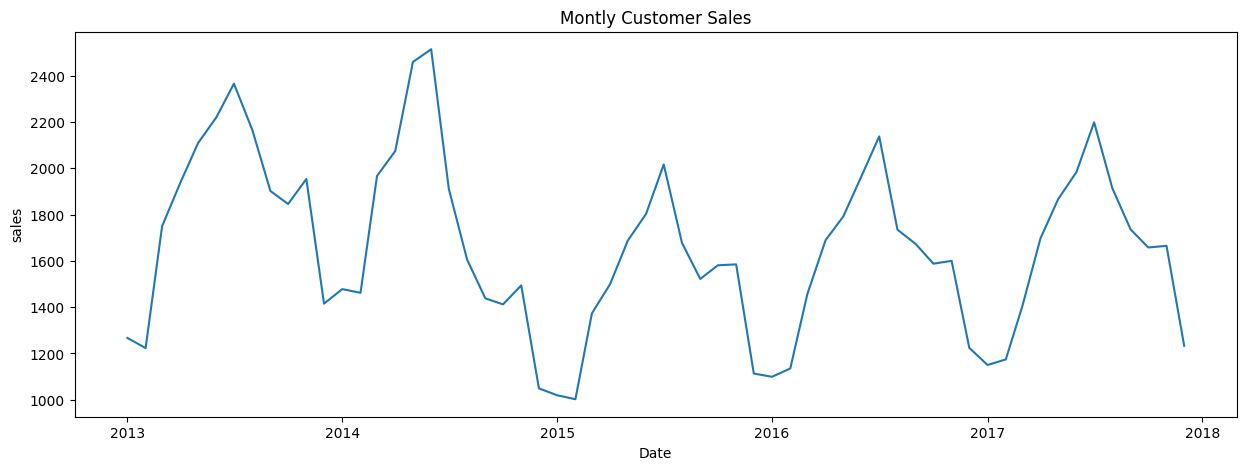

In [199]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales")
plt.show()

In [200]:
# Sales_diff = Selisih Total Penjualan Dengan Bulan Sebelumnya (Increase (+) atau Decrease (-) )
# Contoh Sales_diff pada Row 2 date 2013-03-01 didapatkan dari
# jumlah sales pada date 2013-03-01 (617382) - date 2013-02-01 (459417) didapatkan sales_diff = 157965.0

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,1223,-44.0
2,2013-03-01,1750,527.0
3,2013-04-01,1938,188.0
4,2013-05-01,2109,171.0
5,2013-06-01,2220,111.0
6,2013-07-01,2366,146.0
7,2013-08-01,2168,-198.0
8,2013-09-01,1902,-266.0
9,2013-10-01,1846,-56.0
10,2013-11-01,1954,108.0


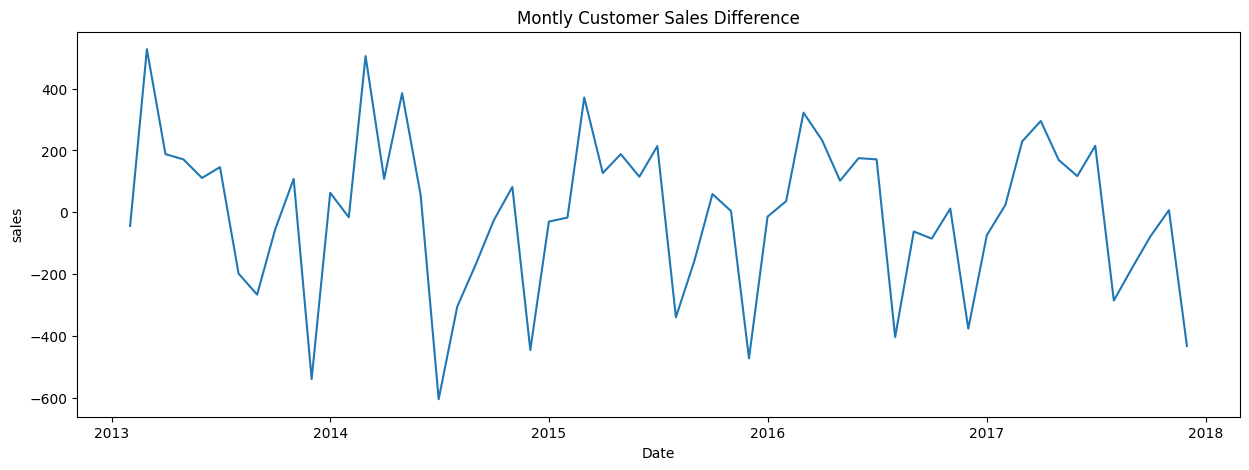

In [201]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales Difference")
plt.show()

In [202]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [203]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-16.0,63.0,-539.0,108.0,-56.0,-266.0,-198.0,146.0,111.0,171.0,188.0,527.0,-44.0
1,505.0,-16.0,63.0,-539.0,108.0,-56.0,-266.0,-198.0,146.0,111.0,171.0,188.0,527.0
2,108.0,505.0,-16.0,63.0,-539.0,108.0,-56.0,-266.0,-198.0,146.0,111.0,171.0,188.0
3,385.0,108.0,505.0,-16.0,63.0,-539.0,108.0,-56.0,-266.0,-198.0,146.0,111.0,171.0
4,55.0,385.0,108.0,505.0,-16.0,63.0,-539.0,108.0,-56.0,-266.0,-198.0,146.0,111.0
5,-604.0,55.0,385.0,108.0,505.0,-16.0,63.0,-539.0,108.0,-56.0,-266.0,-198.0,146.0
6,-305.0,-604.0,55.0,385.0,108.0,505.0,-16.0,63.0,-539.0,108.0,-56.0,-266.0,-198.0
7,-168.0,-305.0,-604.0,55.0,385.0,108.0,505.0,-16.0,63.0,-539.0,108.0,-56.0,-266.0
8,-26.0,-168.0,-305.0,-604.0,55.0,385.0,108.0,505.0,-16.0,63.0,-539.0,108.0,-56.0
9,82.0,-26.0,-168.0,-305.0,-604.0,55.0,385.0,108.0,505.0,-16.0,63.0,-539.0,108.0


In [204]:
# Previous 12 Month
train_data = supervised_data[:-12]
# The Coming 12 Month
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [205]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [206]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("x_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

x_train shape :  (35, 12)
y_train shape :  (35,)
x_test shape :  (12, 12)
y_test shape :  (12,)


In [207]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [208]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[1224, 1150, 1174, 1403, 1698, 1867, 1984, 2199, 1914, 1736, 1658, 1665, 1233]


In [209]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [210]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contain the input features of the data, and also the predict output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [211]:
result_list= []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [212]:
# print(predict_df)
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linaer Regression MSE : ", lr_mse )
print("Linaer Regression MAE : ", lr_mae )
print("Linaer Regression R2 : ", lr_r2 )

Linaer Regression MSE :  89.64503552991287
Linaer Regression MAE :  67.12943740552406
Linaer Regression R2 :  0.900788036543015


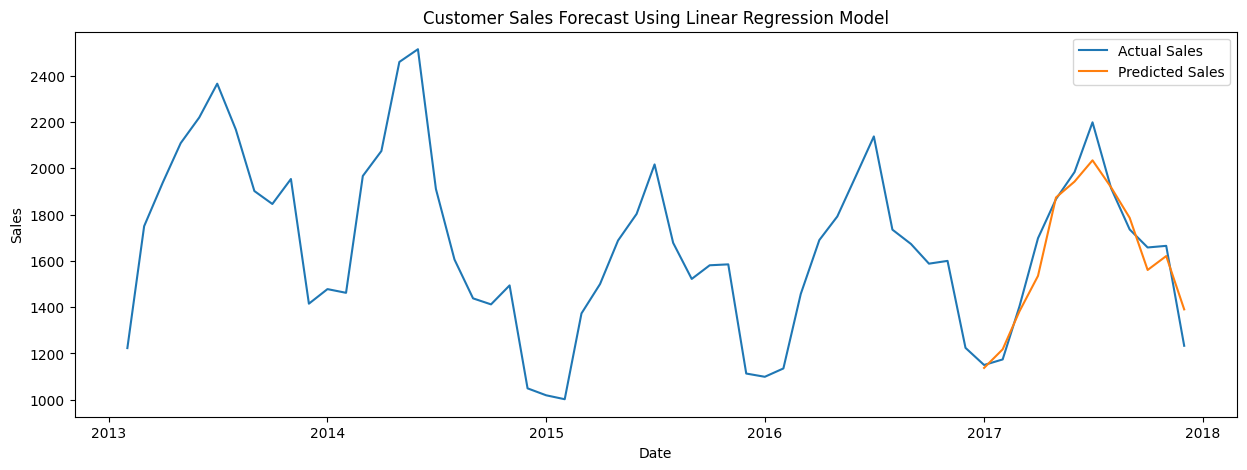

In [213]:
plt.figure(figsize=(15,5))
# Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forecast Using Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()